In [30]:
# imports
from pathlib import Path
import geopandas as gpd
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import rioxarray as rxr
import seaborn as sns

In [2]:
data_path = Path("data")

reference_raster = rasterio.open(data_path / "landcover_2010_nyc_3ft_mn.tif")

In [3]:
# read geoparquet into a gdf
out_data_name = "buildings"
file_ext = "parquet"
bldg_gdf = gpd.read_parquet(data_path / f"{out_data_name}.{file_ext}")

# fill null values in either elevation col with 0s
bldg_gdf.fillna({'groundelev':0,'heightroof':0},inplace=True)

print(f"num of rows in bldg dataset: {len(bldg_gdf)}")

num of rows in bldg dataset: 1083122


In [8]:
# calculate integer roof height relative to sealevel, not grade
bldg_gdf["roof_hgt_from_sealvl"] = (bldg_gdf.heightroof + bldg_gdf.groundelev).astype(
    int
)

In [18]:
bldg_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1083122 entries, 0 to 1083121
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   name                  2254 non-null     object        
 1   bin                   1083122 non-null  float64       
 2   cnstrct_yr            1072853 non-null  float64       
 3   date_lstmo            1083122 non-null  datetime64[ms]
 4   time_lstmo            1083122 non-null  object        
 5   lststatype            1082795 non-null  object        
 6   doitt_id              1083122 non-null  float64       
 7   heightroof            1083122 non-null  float64       
 8   feat_code             1083122 non-null  float64       
 9   groundelev            1083122 non-null  float64       
 10  shape_area            1083122 non-null  float64       
 11  shape_len             1083122 non-null  float64       
 12  base_bbl              1083122 non-

In [10]:
# subset geoparquet to only include MN for testing
mn_bldg_gdf = bldg_gdf.query("base_bbl.str.startswith('1')")

print(f"num of rows in mn bldg dataset: {len(mn_bldg_gdf)}")

num of rows in mn bldg dataset: 45336


In [12]:
count = mn_bldg_gdf.groupby(by=['roof_hgt_from_sealvl']).size()
display(count)

roof_hgt_from_sealvl
-1        1
 0       50
 6        3
 7        7
 8        5
         ..
 1413     1
 1445     1
 1461     1
 1486     1
 1630     1
Length: 686, dtype: int64

<Axes: xlabel='roof_hgt_from_sealvl'>

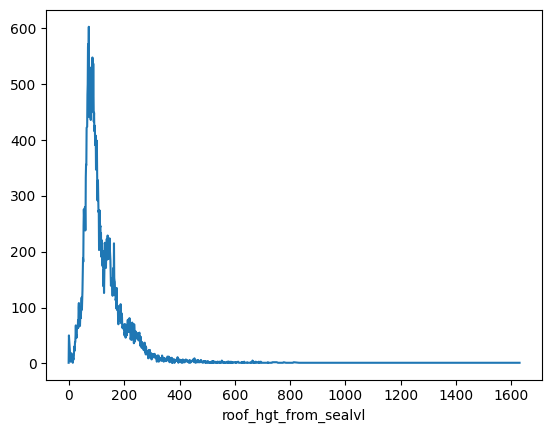

In [17]:
count.plot()

In [36]:
## rasterize bldg footprints

geom = [shapes for shapes in mn_bldg_gdf.geometry]

# generate tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = (
    (geom, value)
    for geom, value in zip(mn_bldg_gdf.geometry, mn_bldg_gdf["roof_hgt_from_sealvl"])
)

# Rasterize vector using the shape and transform of the raster
rasterized = rasterio.features.rasterize(
    shapes=geom_value,
    out_shape=reference_raster.shape,
    transform=reference_raster.transform,
    all_touched=True,
    fill=0,  # background value
    merge_alg=rasterio.enums.MergeAlg.replace,
    # dtype=np.int16,
)

In [38]:
out_raster = "mn_bldg_raster.tif"

with rasterio.open(
    fp=data_path / f"{out_raster}",
    mode="w",
    driver="GTiff",
    width=reference_raster.width,   # width in rows
    height=reference_raster.height, # height in rows
    count=1,                        # number of bands
    crs=reference_raster.crs,
    transform=reference_raster.transform,
    dtype=rasterio.float32,           # dtype must be float, else lose elev resolution
) as dst:
    dst.write(
        arr=rasterized,             # array to write to raster
        indexes=1,                  # bands to write to
        )

In [39]:
mn_bldg_raster = rasterio.open(data_path / "mn_bldg_raster.tif")

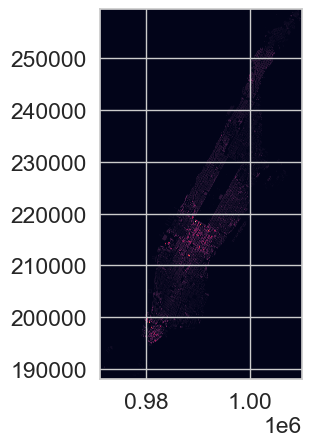

<Axes: >

In [40]:
rasterio.plot.show(mn_bldg_raster)

In [42]:
# Prettier plotting with seaborn
sns.set_theme(font_scale=1.5, style="whitegrid")

In [43]:
# Open data 
mn_bldg_xarray = rxr.open_rasterio(data_path / "mn_bldg_raster.tif", masked=True)

# View object dimensions
mn_bldg_xarray.shape

(1, 23820, 13017)

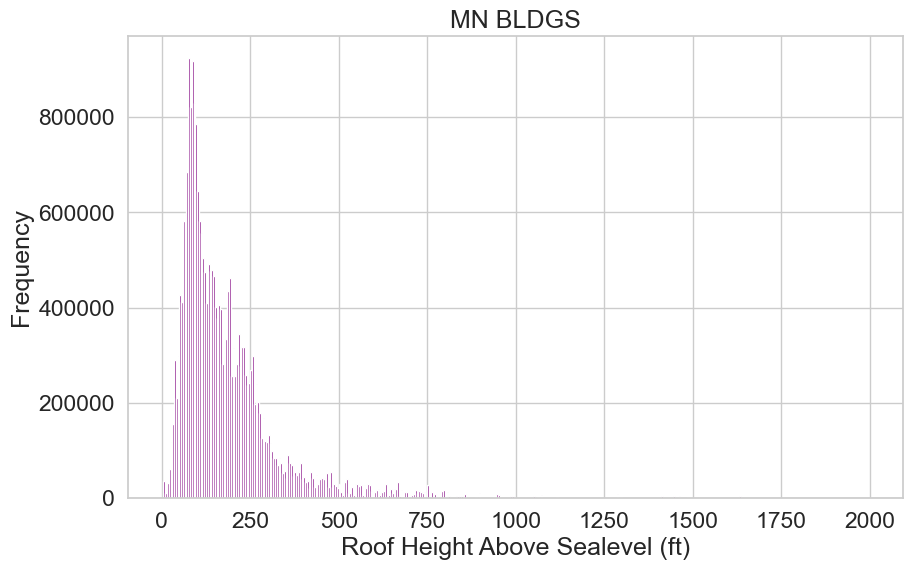

In [71]:
# Plot a histogram
bins = [x for x in range(5,2000,5)]
f, ax = plt.subplots(figsize=(10, 6))
mn_bldg_xarray.plot.hist(
    ax=ax,
    color="purple",
    bins=bins,
)
ax.set(title="MN BLDGS", xlabel="Roof Height Above Sealevel (ft)", ylabel="Frequency")

plt.show()